[View in Colaboratory](https://colab.research.google.com/github/paulanavarretec/RecSys-Tarea1/blob/master/Recsys_Tarea1.ipynb)

# Recommender Algorithms for a Beer Selling platform


---



In this asisgnment I develop several Recommender algorithms and test their performance. I use pyreclab Python library, developed by IALab & SocVis from the Pontifical Catholic University of Chile.

The algorithms developed ahead are:

> UserKnn

> ItemKnn

> SlopeOne

> SVD


> ALS o ALScg: (este modelo lo puede usar para la tarea de ranking. Si tiene problemas con pyreclab, puede usar la biblioteca implicit1).


---

## Step 1: Load and Visualize data

Download to local computer the relevant files through the following links:

(update links)

https://drive.google.com/file/d/1Anro2DyEgN0sUHXFyxVe2qoSya6hzQSp/view?usp=sharing

https://drive.google.com/file/d/1Awy3QKCdkSpNeRXATqRBUMi56M47Ia0n/view?usp=sharing

https://drive.google.com/file/d/1B7QhEodQ13QlOHOTp9zaa52exlfgAOl3/view?usp=sharing


---



In [3]:
#Run this cell. You must upload the files to be used to analyse: training_data.csv, test_rating_data.csv y ranking_users.txt
from google.colab import files
uploaded = files.upload()

Saving training_data.csv to training_data.csv
Saving ranking_users.txt to ranking_users (1).txt
Saving test_rating_data.csv to test_rating_data (1).csv


*training_data.csv* and *test_data.csv* files have tuples of the form {'sampleID', 'userID',  'itemID',  'styleID', 'rating', 'brewerID', 'timestamp'} wich is the information of user preferences among the diferent beer features.

In [0]:
import pandas as pd

train_file = pd.read_csv('training_data.csv',
                         sep=',',
                         names = ['obsNo','userID', 'itemID', 'styleID', 'rating','brewerID','timestamp'],
                         header=0)

test_file = pd.read_csv('test_rating_data.csv',                    
                         sep=',',
                         names = ['obsNo','itemID',  'styleID',  'userID',  'brewerID',   'timestamp'],
                         header=0)

### Training Data

The head and tail of the training_data.csv can be visualized as follows, among with other relevant information.

In [53]:
print(train_file.head())
print(train_file.tail(),'\n\n')

print(train_file.nunique())


uniqueVals = train_file["styleID"].unique()
uniqueVals = train_file["brewerID"].unique()
print("Son iguales?",bool(set(train_file['styleID']).intersection(train_file["brewerID"])))

   obsNo  userID  itemID  styleID  rating  brewerID   timestamp
0      0    4924   11757     1199     4.5      1199  1247372118
1      1    4924    5441     1199     4.5      1199  1209176445
2      2    4924   19960     1199     5.0      1199  1223914717
3      3    2916   55900     1199     2.5      1199  1291336093
4      4    2916   57110    14879     4.0     14879  1279318326
       obsNo  userID  itemID  styleID  rating  brewerID   timestamp
44347  44374    3230   11757     1199     5.0      1199  1286494547
44348  44375    4630   11757     1199     2.5      1199  1254948632
44349  44376    6118   20470      394     4.0       394  1204330634
44350  44377    6118    1324      263     3.5       263  1212967655
44351  44378    7268    1504      568     5.0       568  1157647130 


obsNo        44352
userID        8318
itemID        1836
styleID        210
rating          10
brewerID       210
timestamp    43905
dtype: int64
Son iguales? True


#### Summary statistics

In [60]:
print('Summary\n\n',train_file.describe(),'\n')
print('Median:\n',train_file.median(),'\n') # Sample median of rating values
print('Variance:\n',train_file.var(),'\n')    # Sample variance of rating values
print('Standard deviation:\n',train_file.std(),'\n')     # Sample standard deviation of rating values
print('Skew:\n',train_file.skew(),'\n')    # Skewness of rating values
print('Kurtosis:\n',train_file.kurt(),'\n')    # Kurtosis of rating values

Summary

               obsNo        userID        itemID       styleID        rating  \
count  44352.000000  44352.000000  44352.000000  44352.000000  44352.000000   
mean   22191.016031   3205.841698  21296.386273   2972.899238      3.864910   
std    12812.864346   2391.127797  18548.835555   5037.020714      0.712695   
min        0.000000      1.000000    175.000000      1.000000      0.000000   
25%    11096.750000   1130.000000   5441.000000    395.000000      3.500000   
50%    22184.500000   2763.000000  17538.000000   1199.000000      4.000000   
75%    33290.250000   5013.250000  34146.000000   1315.000000      4.500000   
max    44378.000000   8320.000000  77207.000000  27797.000000      5.000000   

           brewerID     timestamp  
count  44352.000000  4.435200e+04  
mean    2972.899238  1.229025e+09  
std     5037.020714  7.173668e+07  
min        1.000000  9.262944e+08  
25%      395.000000  1.184526e+09  
50%     1199.000000  1.243485e+09  
75%     1315.000000  1.286

In [67]:
(train_file.corr())    # Correlation Matrix Of Values

,obsNo,userID,itemID,styleID,rating,brewerID,timestamp
obsNo,1.000000,-0.003365,0.006654,-0.000982,0.008494,-0.000982,0.001472
userID,-0.003365,1.000000,-0.314421,-0.166903,-0.023358,-0.166903,-0.638473
itemID,0.006654,-0.314421,1.000000,0.524710,-0.019572,0.524710,0.424763
styleID,-0.000982,-0.166903,0.524710,1.000000,-0.082091,1.000000,0.206634
rating,0.008494,-0.023358,-0.019572,-0.082091,1.000000,-0.082091,0.059495
brewerID,-0.000982,-0.166903,0.524710,1.000000,-0.082091,1.000000,0.206634
timestamp,0.001472,-0.638473,0.424763,0.206634,0.059495,0.206634,1.000000


In [68]:
(train_file.cov())    # Covariance Matrix Of Values

,obsNo,userID,itemID,styleID,rating,brewerID,timestamp
obsNo,1.641695e+08,-1.030805e+05,1.581421e+06,-6.334947e+04,7.756751e+01,-6.334947e+04,1.353343e+09
userID,-1.030805e+05,5.717492e+06,-1.394539e+07,-2.010202e+06,-3.980498e+01,-2.010202e+06,-1.095183e+11
itemID,1.581421e+06,-1.394539e+07,3.440593e+08,4.902411e+07,-2.587404e+02,4.902411e+07,5.652037e+11
styleID,-6.334947e+04,-2.010202e+06,4.902411e+07,2.537158e+07,-2.946954e+02,2.537158e+07,7.466486e+10
rating,7.756751e+01,-3.980498e+01,-2.587404e+02,-2.946954e+02,5.079335e-01,-2.946954e+02,3.041758e+06
brewerID,-6.334947e+04,-2.010202e+06,4.902411e+07,2.537158e+07,-2.946954e+02,2.537158e+07,7.466486e+10
timestamp,1.353343e+09,-1.095183e+11,5.652037e+11,7.466486e+10,3.041758e+06,7.466486e+10,5.146151e+15


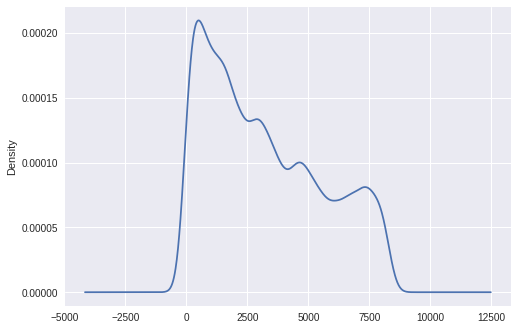

In [66]:
train_file['userID'].plot.kde()

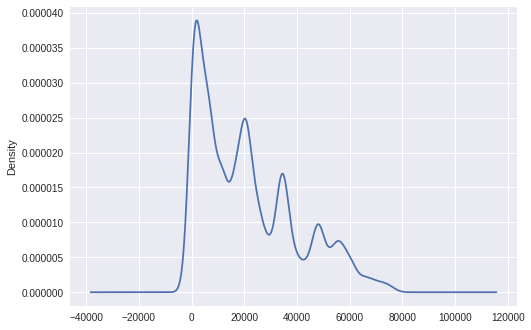

In [78]:
import numpy as np
ser = pd.Series(train_file['itemID'].tolist())

ser.plot.kde()

   userID  itemsRated
0       1          22
1       2          18
2       3          16
3       4          39
4       5          12
      userID  itemsRated
8313    8316           2
8314    8317           1
8315    8318           1
8316    8319           1
8317    8320           1
count    8318.000000
mean        5.332051
std         9.921520
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       181.000000
dtype: float64


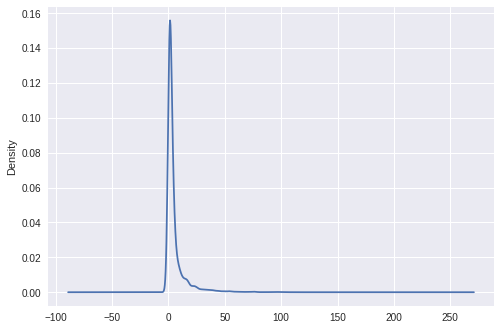

In [117]:
print(train_file.groupby(['userID']).size().reset_index(name='itemsRated').head())
print(train_file.groupby(['userID']).size().reset_index(name='itemsRated').tail())

ser = pd.Series(train_file.groupby(['userID']).size().reset_index(name='itemsRated')['itemsRated'].tolist())
print(ser.describe())
ser.plot.kde()

   itemID  usersRated
0     175          71
1     176         118
2     178          83
3     429        1182
4     436         443
      itemID  usersRated
1831   76997           2
1832   76998           1
1833   76999           1
1834   77198           1
1835   77207           1
count    1836.000000
mean       24.156863
std       113.849140
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max      2205.000000
dtype: float64


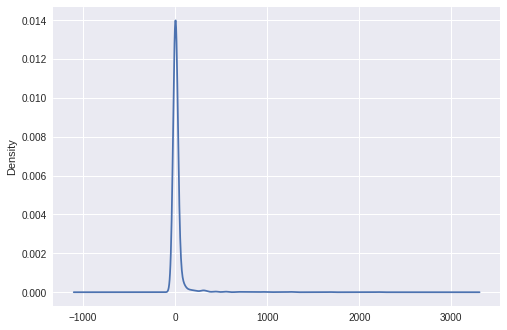

In [118]:
print(train_file.groupby(['itemID']).size().reset_index(name='usersRated').head())
print(train_file.groupby(['itemID']).size().reset_index(name='usersRated').tail())

ser = pd.Series(train_file.groupby(['itemID']).size().reset_index(name='usersRated')['usersRated'].tolist())
print(ser.describe())
ser.plot.kde()

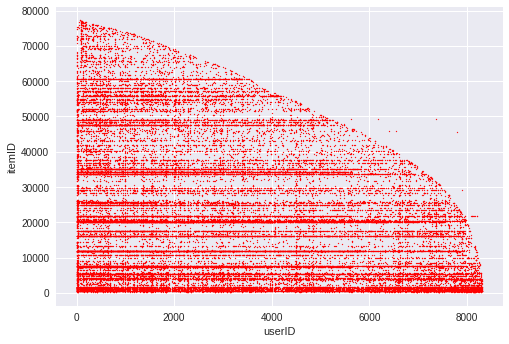

In [11]:
train_file.plot.scatter('userID','itemID', s=1, c='red')

In [47]:
train_file.nunique()

obsNo        44352
userID        8318
itemID        1836
styleID        210
rating          10
brewerID       210
timestamp    43905
dtype: int64

### Test Data

The head and tail of the test_rating_data.csv can visualized as follows among with other relevant information.

In [5]:
print(test_file.head())
print(test_file.tail())



   obsNo  itemID  styleID  userID  brewerID   timestamp
0      0   39289    14756     715     14756  1323055558
1      1    3939     1417    4944      1417  1253267842
2      2   47695    14879    4890     14879  1254528673
3      3    7348     1199    5324      1199  1242171391
4      4   37403     1199    5544      1199  1257734244
      obsNo  itemID  styleID  userID  brewerID   timestamp
2940   2940   47658     1199    4342      1199  1251082110
2941   2941   11757     1199    5765      1199  1226798468
2942   2942    3365      395    5462       395  1251178465
2943   2943   10785     1075    3342      1075  1298939599
2944   2944    7675     3268    3728      3268  1294956837
